In [23]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from node2vec import Node2Vec
from pathlib import Path
import sqlite3

from functools import reduce
from typing import List, Dict, Optional, Union, Tuple, Callable
from itertools import combinations
from statistics import median, mean
from enum import Enum

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### Make Authors Graph

In [24]:
class open_cursor(object):
    def __init__(self, db: Path):
        assert db.exists()
        self.conn = sqlite3.connect(str(db))
        self.cursor = None

    def __enter__(self):
        self.cursor = self.conn.cursor()
        return self.cursor

    def __exit__(self, exc_class, exc, traceback):
        self.conn.commit()
        self.cursor.close()
        self.conn.close()
        

class DatabaseHandler:
    def __init__(self, file: Path):
        self._file = file

    def __str__(self):
        return str(self._file)

    def get_authors_by_year(self, year: int):
        sql = """SELECT Article.ID, Has.Author_Name
                 FROM Article, Has
                 WHERE Article.Year = ? AND Has.Article_Id = Article.ID"""

        result = {}
        with open_cursor(self._file) as cursor:
            cursor.execute(sql, (year,))
            for raw in cursor:
                article, author = raw
                result[article] = result.get(article) or []
                result[article].append(author)

        return result

    def get_authors(self):
        sql = """SELECT Article.ID, Has.Author_Name, Article.Year
                 FROM Article, Has
                 WHERE Has.Article_Id = Article.ID"""

        result = {}
        with open_cursor(self._file) as cursor:
            cursor.execute(sql)

            for raw in cursor:
                article, author, year = raw
                result[year] = result.get(year) or {}
                result[year][article] = result[year].get(article) or []
                result[year][article].append(author)

        return result

In [25]:
def create_author_graph(db: Union[Path, DatabaseHandler], year: Optional[Union[int, Tuple[int, int]]] = None):
    
    # if we don't have any year
    if isinstance(db, Path):
        db = DatabaseHandler(db)

    # if there's only one year    
    if isinstance(year, int):
        data = db.get_authors_by_year(year).values()

    # if there's time period    
    elif isinstance(year, tuple):
        start, end = year
        data = []
        for year, year_data in db.get_authors().items():
            if year > start and year < end:
                data += list(year_data.values())
    
    graph = nx.Graph()
    
    
    for author_list in data:
        for source, destination in combinations(author_list, 2):
            if graph.has_edge(source, destination):
                graph[source][destination]['weight'] += 1
            else:
                graph.add_edge(source, destination, weight=1)

    return graph

In [26]:
db = DatabaseHandler(Path("test.db"))

training = create_author_graph(db, (2010, 2016))
testing = create_author_graph(db, (2017, 2019))

### Vizualization of the graphs 

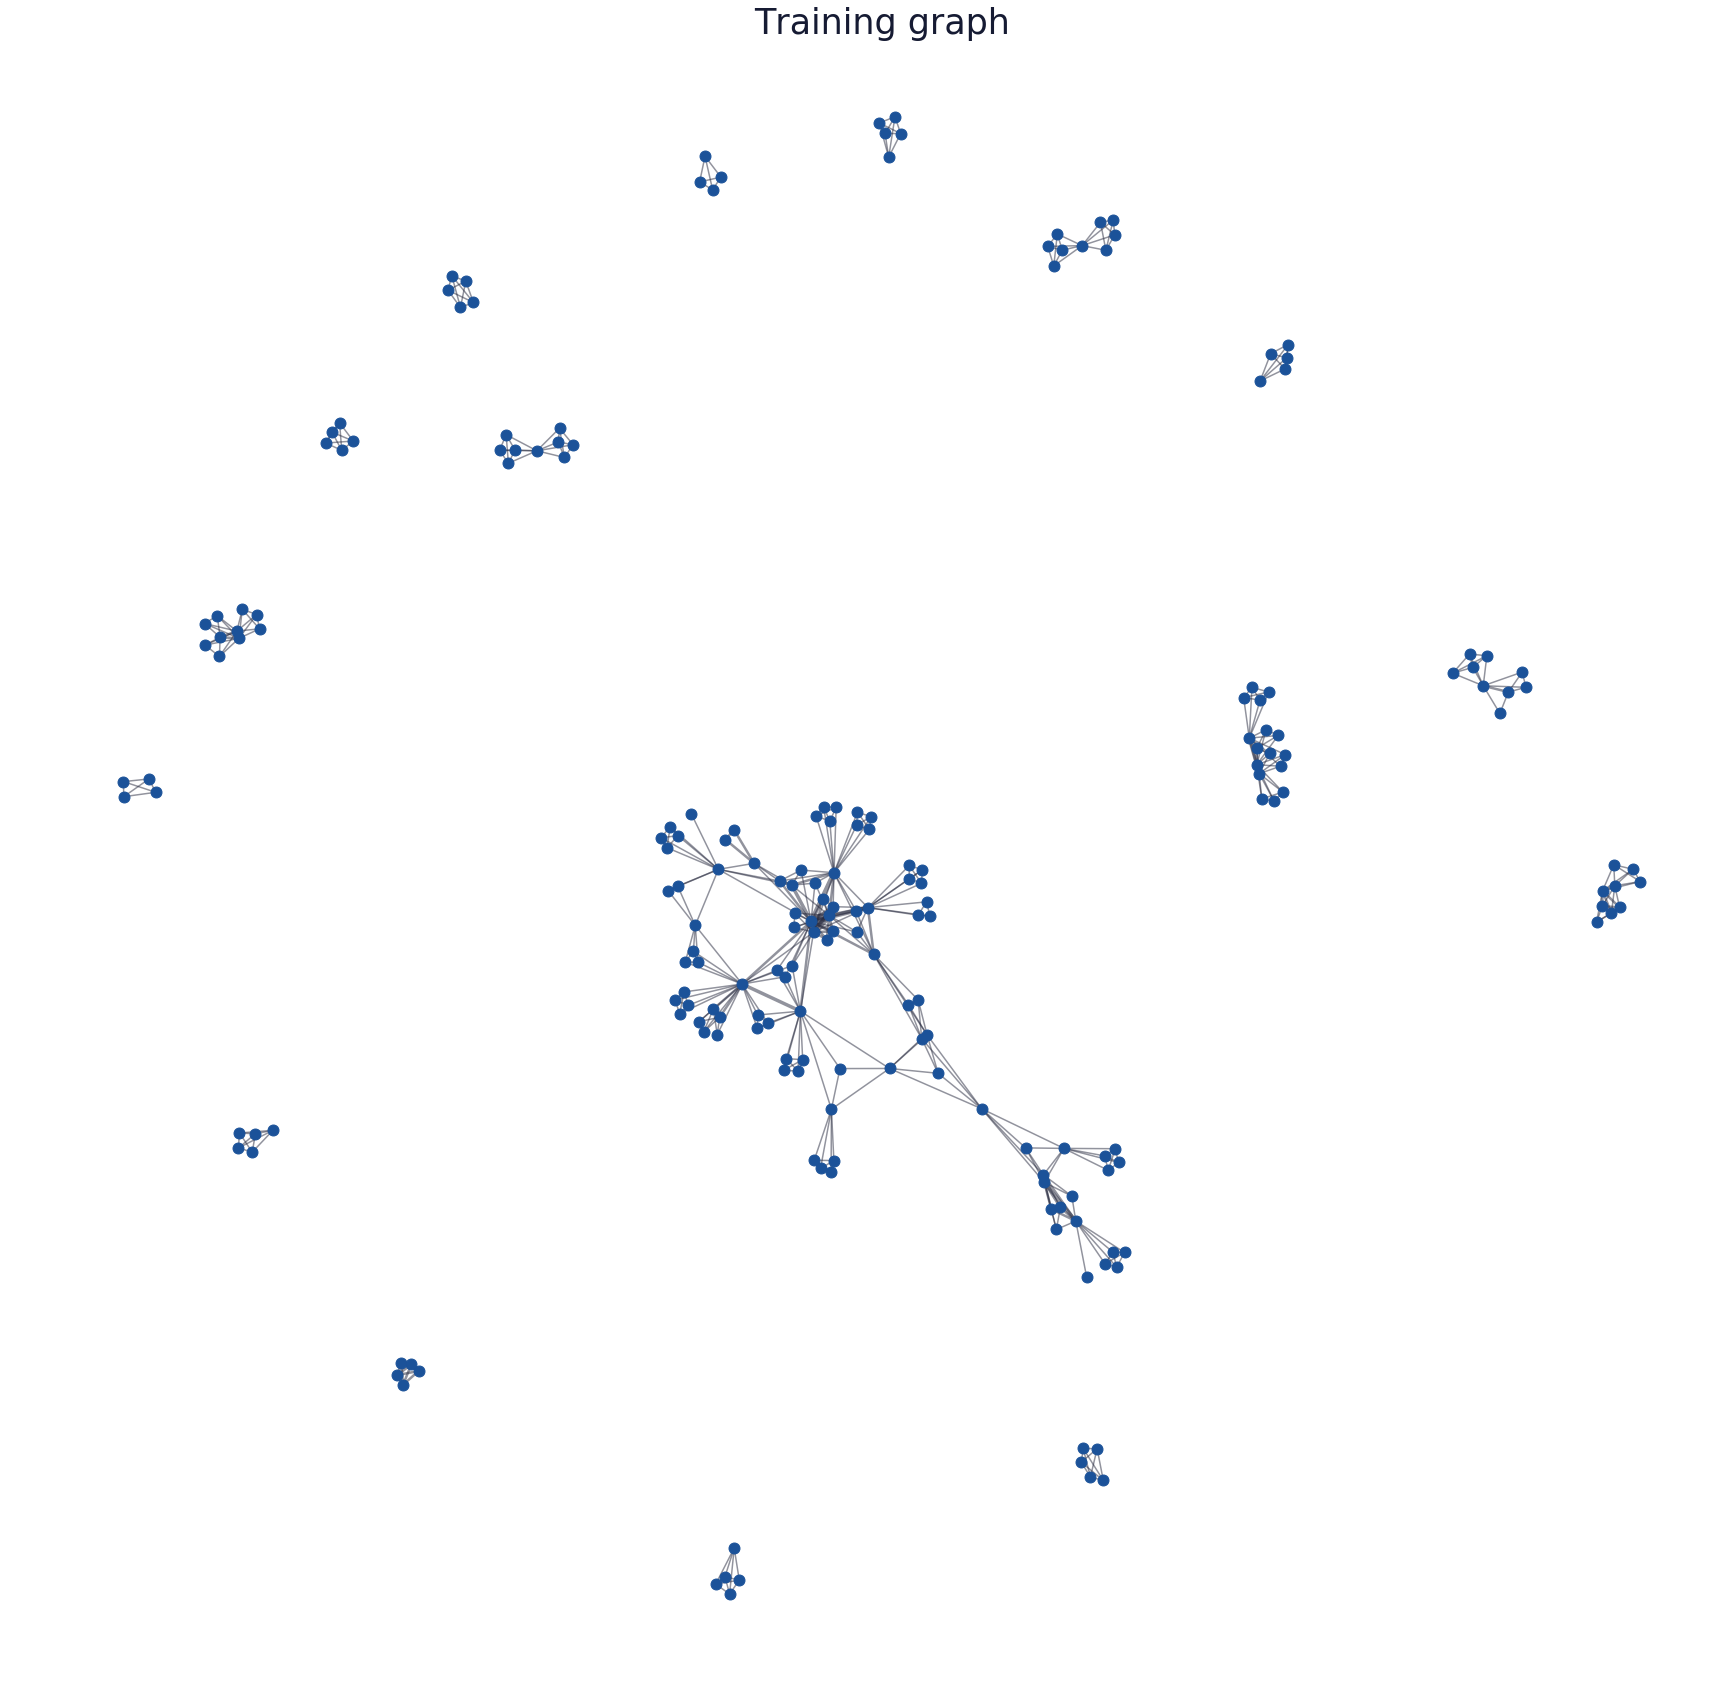

There are  210  nodes in the training graph
There are  514 edges in the training graph


In [27]:
nodes = training.nodes()
plt.figure(figsize=(30, 30))
    
pos = nx.spring_layout(training)

weights = nx.get_edge_attributes(training, 'weight')
widths = [weights[edge] + 0.5 for edge in training.edges()]

plt.title('Training graph', color="#161B33", fontsize=35)
nx.draw_networkx_edges(training, pos, width=widths, alpha=0.5, edge_color='#25283D')
nx.draw_networkx_nodes(G=training, nodelist=nodes, pos=pos, label='', node_color='#1B5299', node_size=120)

plt.axis('off')
plt.show()

v = len(training.nodes())
e = len(training.edges())
print('There are ', v, ' nodes in the training graph')
print('There are ', e, 'edges in the training graph')

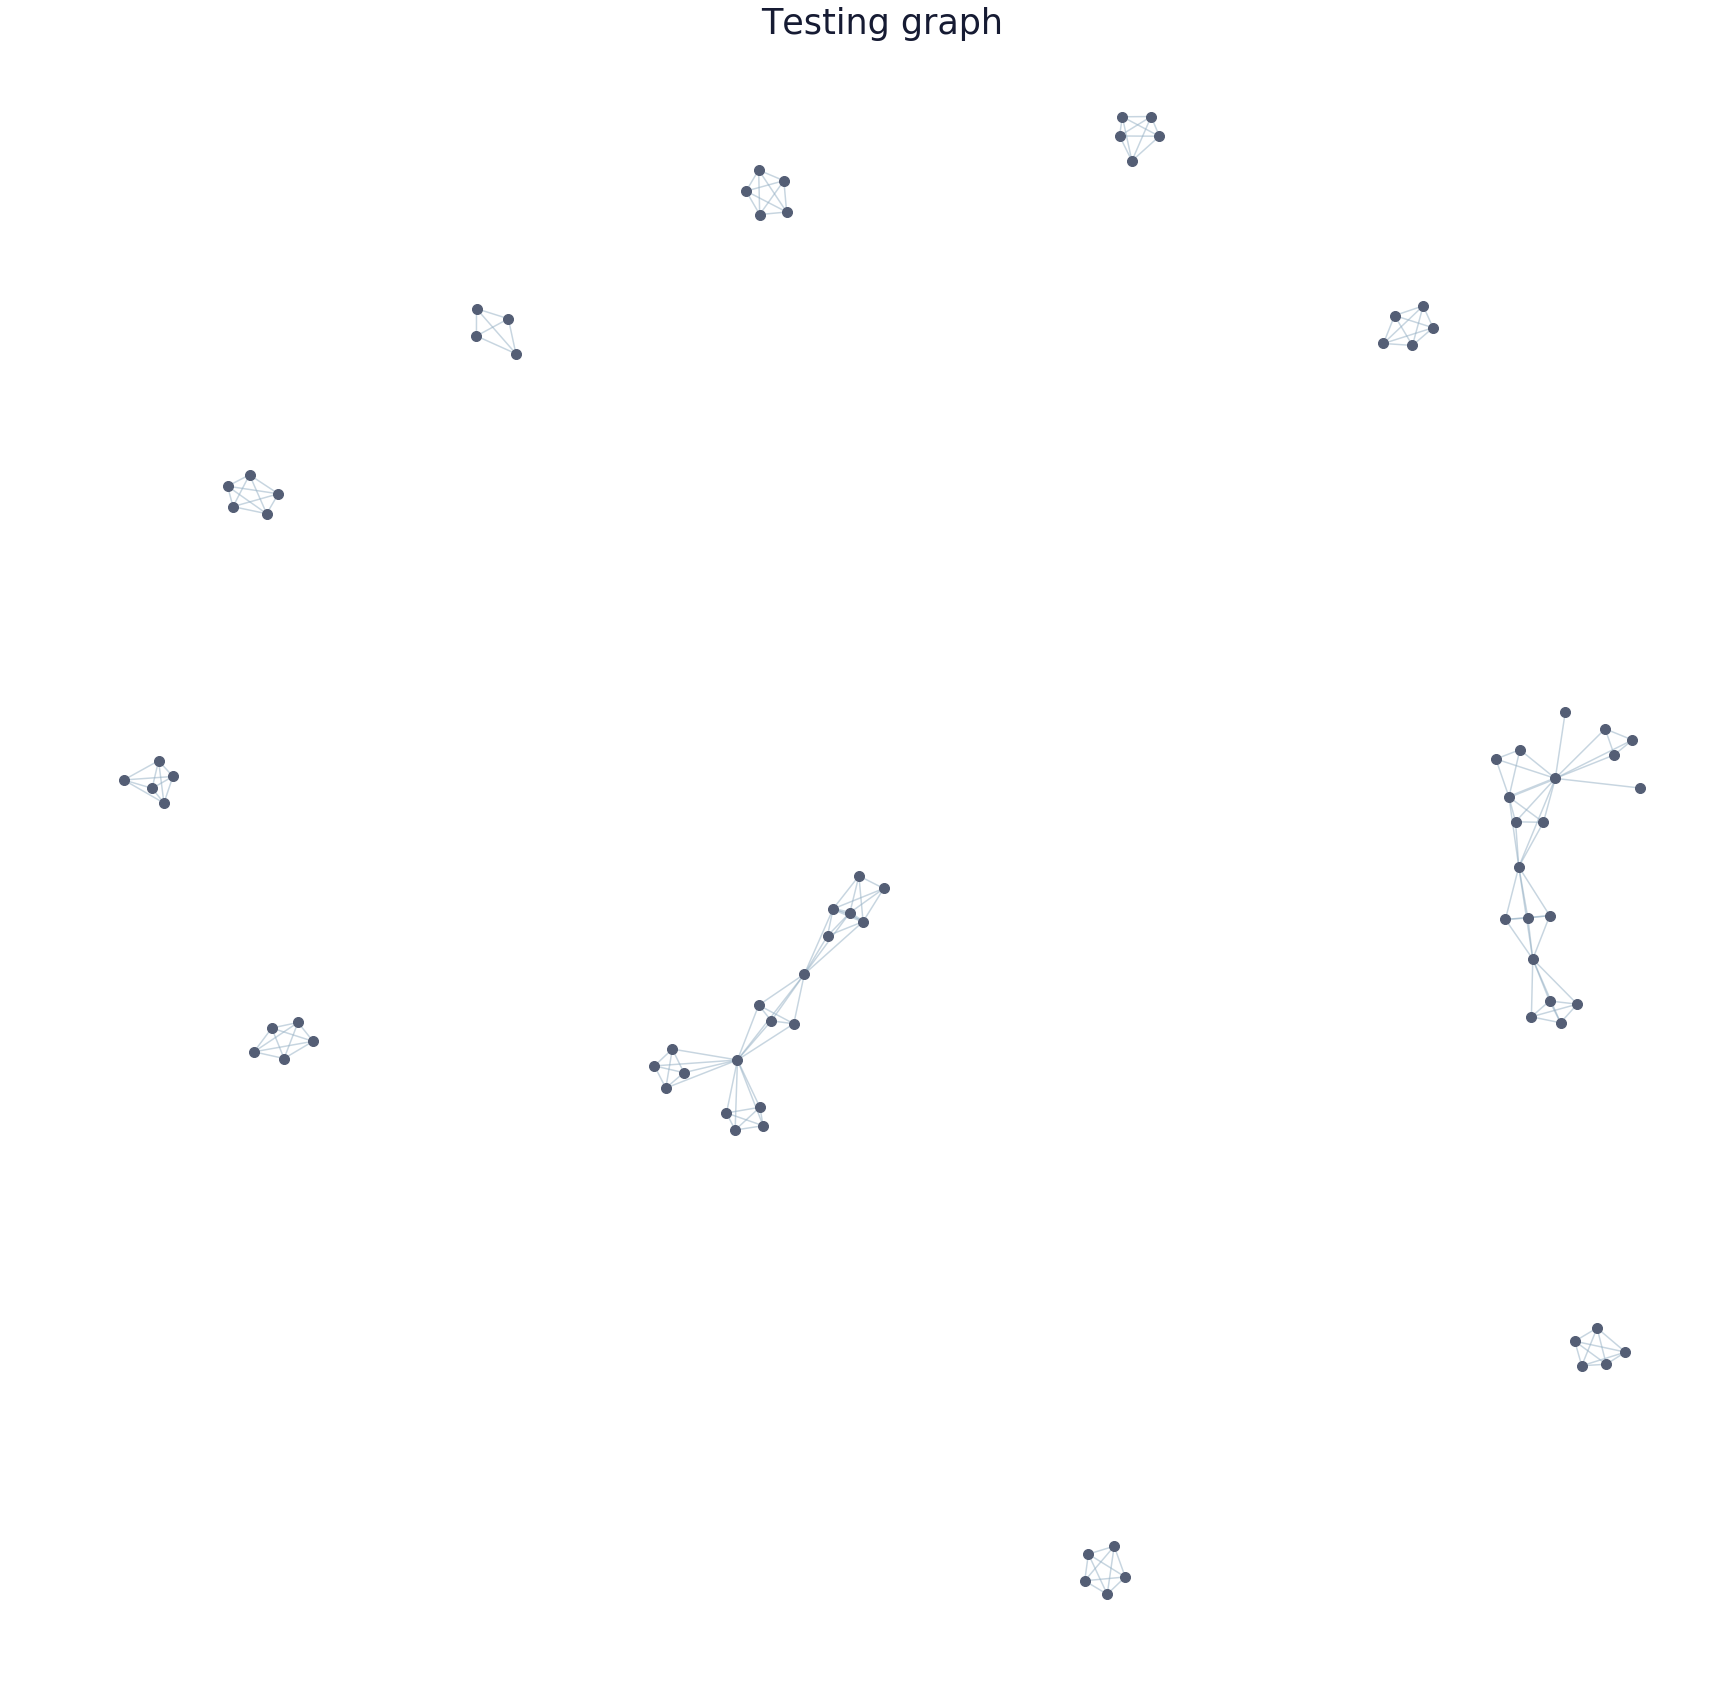

There are  83  nodes in the testing graph
There are  176 edges in the testing graph


In [28]:
nodes = testing.nodes()
plt.figure(figsize=(30, 30))
    
pos = nx.spring_layout(testing)

weights = nx.get_edge_attributes(testing, 'weight')
widths = [weights[edge] + 0.5 for edge in testing.edges()]

plt.title('Testing graph', color="#161B33", fontsize=35)
nx.draw_networkx_edges(testing, pos, width=widths, alpha=0.5, edge_color='#91ADC2')
nx.draw_networkx_nodes(training, pos, nodelist=nodes, node_color='#545E75', label='', node_size=100)

plt.axis('off')
plt.show()

v = len(testing.nodes())
e = len(testing.edges())
print('There are ', v, ' nodes in the testing graph')
print('There are ', e, 'edges in the testing graph')

### Features

In [29]:
class Feature(Enum):
    # 2 features based on neighborhood
    NeighborsMedian = 0 
    NeighborsMean = 1
    
    # 2 fetures based on shortest path
    ShortPathMedian = 2
    ShortPathMean = 3
    
    # Node2vec
    Node2VecMin = 4
    Node2VecMax = 5

In [30]:
def get_feature(graph, criteria: Callable, is_edge_need: bool = True):
    pairs = tuple(combinations(graph.nodes(), r=2))
    feature = []
    for s, d in pairs:
        if is_edge_need:
            if not graph.has_edge(s, d):
                val = False
            else:
                val = criteria(graph, s, d)
        else:
            val = criteria(graph, s,d)

        feature.append(val)
    return feature


def create_simple_feature():
    feature = {}
    median_weight = median(training_weights.values())

    # if edge's weight is greater than the median value
    feature[Feature.NeighborsMedian] = get_feature(training,
                                                lambda graph,s,d: graph[s][d]['weight'] > median_weight)

    mean_weight = mean(training_weights.values())
    
    # if edge's weight is greater than the mean value
    feature[Feature.NeighborsMean] = get_feature(training,
                                               lambda graph,s,d: graph[s][d]['weight'] > mean_weight)

    def get_path(graph: nx.Graph, s, d):
        # let's find the shortest path from s to d using Dijkstra algorithm
        try:
            path = nx.dijkstra_path(graph, s, d, weight='weight')
        except nx.exception.NetworkXNoPath:
            return 0

        path_weigh = 0.

        for index, current in enumerate(path[1:]):
            prev = path[index]
            path_weigh += graph[prev][current]['weight']
        return path_weigh
    
    paths = get_feature(training, lambda graph, s, d: get_path(graph, s, d), is_edge_need=False)
    
    mean_path = mean(paths)
    median_path = median(paths)
    
    # if shortest path is greater than median path
    feature[Feature.ShortPathMedian] = tuple(path > median_path for path in paths)
    
    # if shortest path is greater than mean path
    feature[Feature.ShortPathMean] = tuple(path > mean_path for  path in paths)
    
    return feature

In [31]:
training_weights = nx.get_edge_attributes(training, 'weight')
testing_weights = nx.get_edge_attributes(testing, 'weight')

training_pairs = tuple(combinations(training.nodes(), r=2))
testing_pairs = tuple(combinations(testing.nodes(), r=2))

target = list(testing.has_edge(s, d) for s,d in training_pairs)

feature = create_simple_feature()

In [32]:
n2v = Node2Vec(graph=training, workers=3)
# probabilities of the existence of the edge between the current node and its neighbors
n2v = {name: value['probabilities'] for name, value in n2v.d_graph.items()}

feature[Feature.Node2VecMin] = [] 
feature[Feature.Node2VecMax] = []

for s, d in training_pairs:
    if s not in n2v:
        max_, min_ = 0, 0
    else:
        if d not in n2v[s]:
            max_, min_ = 0, 0
        else:
            max_, min_ = max(n2v[s][d]), min(n2v[s][d])
            
    # if max probability is greater than 0.3 
    feature[Feature.Node2VecMax].append(max_ > 0.3)
    
    # if min probability is less than 0.3 
    feature[Feature.Node2VecMin].append(min_ < 0.3)

Computing transition probabilities: 100%|██████████| 210/210 [00:00<00:00, 4091.26it/s]


In [33]:
features = list(zip(feature[Feature.NeighborsMedian],
                        feature[Feature.NeighborsMean],
                        feature[Feature.ShortPathMean],
                        feature[Feature.ShortPathMedian],
                        feature[Feature.Node2VecMax],
                        feature[Feature.Node2VecMin]))


target = np.array(target)

### Classification algorithms

In [54]:
# 1. K-nearest neighbors
model = KNeighborsClassifier(n_neighbors=3)
model.fit(features, target)
KNeighbors_f = model.predict(features)

# 2. Random forest
model_rforest = RandomForestClassifier(max_depth=5, n_estimators=10)
model_rforest.fit(features, target)
RandomForest_f = model_rforest.predict(features)

# 3. C-Support Vector Classification                  
model_svc = SVC()
model_svc.fit(features, target)
svc_f = model_svc.predict(features)

# 4. Logistic Regression              
model_log = LogisticRegression(random_state=0)
model_log.fit(features, target)
log_f = model_log.predict(features)
   
# 5. Gaussian Naive Bayes              
model_NB = GaussianNB()
model_NB.fit(features, target)
NB_f = model_NB.predict(features)              

In [46]:
print('Accuracy: \n')
print('for KNeighborsClassifier:', accuracy_score(y_true=target, y_pred=KNeighbors_f))
print('for RandomForestClassifier:',accuracy_score(y_true=target, y_pred=RandomForest_f))
print('for SVC:',accuracy_score(y_true=target, y_pred=svc_f))
print('for LogisticRegression:',accuracy_score(y_true=target, y_pred=log_f))
print('for GaussianNB:',accuracy_score(y_true=target, y_pred=NB_f))

Accuracy: 

for KNeighborsClassifier: 0.9992253360674413
for RandomForestClassifier: 0.9992253360674413
for SVC: 0.9992253360674413
for LogisticRegression: 0.9992253360674413
for GaussianNB: 0.9963545226703121


In [47]:
print('Precision binary: \n')
print('for KNeighborsClassifier:', precision_score(y_true=target, y_pred=KNeighbors_f, average='binary'))
print('for RandomForestClassifier:', precision_score(y_true=target, y_pred=RandomForest_f, average='binary'))
print('for SVC:', precision_score(y_true=target, y_pred=svc_f, average='binary'))
print('for LogisticRegression:', precision_score(y_true=target, y_pred=log_f, average='binary'))
print('for GaussianNB:', precision_score(y_true=target, y_pred=NB_f, average='binary'))

Precision binary: 

for KNeighborsClassifier: 0.0
for RandomForestClassifier: 0.0
for SVC: 0.0
for LogisticRegression: 0.0
for GaussianNB: 0.029850746268656716


In [48]:
print('Precision norm: \n')
print('for KNeighborsClassifier:', precision_score(y_true=target, y_pred=KNeighbors_f))
print('for RandomForestClassifier:', precision_score(y_true=target, y_pred=RandomForest_f))
print('for SVC:', precision_score(y_true=target, y_pred=svc_f))
print('for LogisticRegression:', precision_score(y_true=target, y_pred=log_f))
print('for GaussianNB:', precision_score(y_true=target, y_pred=NB_f))

Precision norm: 

for KNeighborsClassifier: 0.0
for RandomForestClassifier: 0.0
for SVC: 0.0
for LogisticRegression: 0.0
for GaussianNB: 0.029850746268656716


In [49]:
print('Recall: \n')
print('for KNeighborsClassifier:', recall_score(y_true=target, y_pred=KNeighbors_f))
print('for RandomForestClassifier:', recall_score(y_true=target, y_pred=RandomForest_f))
print('for SVC:', recall_score(y_true=target, y_pred=svc_f))
print('for LogisticRegression:', recall_score(y_true=target, y_pred=log_f))
print('for GaussianNB:', recall_score(y_true=target, y_pred=NB_f))

Recall: 

for KNeighborsClassifier: 0.0
for RandomForestClassifier: 0.0
for SVC: 0.0
for LogisticRegression: 0.0
for GaussianNB: 0.11764705882352941


In [50]:
print('F1 score: \n')
print('for KNeighborsClassifier:', f1_score(y_true=target, y_pred=KNeighbors_f))
print('for RandomForestClassifier:', f1_score(y_true=target, y_pred=RandomForest_f))
print('for SVC:', f1_score(y_true=target, y_pred=svc_f))
print('for LogisticRegression:', f1_score(y_true=target, y_pred=log_f))
print('for GaussianNB:', f1_score(y_true=target, y_pred=NB_f))

F1 score: 

for KNeighborsClassifier: 0.0
for RandomForestClassifier: 0.0
for SVC: 0.0
for LogisticRegression: 0.0
for GaussianNB: 0.047619047619047616


In [51]:
target = target.astype(np.float32)

print('MSE: \n') 
print('for KNeighborsClassifier:', mean_squared_error(y_true=target, y_pred=KNeighbors_f.astype(np.float32)))
print('for RandomForestClassifier:', mean_squared_error(y_true=target, y_pred=RandomForest_f.astype(np.float32)))
print('for SVC:', mean_squared_error(y_true=target, y_pred=svc_f.astype(np.float32)))
print('for LogisticRegression:', mean_squared_error(y_true=target, y_pred=log_f.astype(np.float32)))
print('for GaussianNB:', mean_squared_error(y_true=target, y_pred=NB_f.astype(np.float32)))

MSE: 

for KNeighborsClassifier: 0.00077466393
for RandomForestClassifier: 0.00077466393
for SVC: 0.00077466393
for LogisticRegression: 0.00077466393
for GaussianNB: 0.0036454774
